# Imports & Configuration

In [1]:
import cv2
print(f"OpenCV Version: {cv2.__version__}")
print(f"Has BRISK: {hasattr(cv2, 'BRISK_create')}")
try:
    print(f"Has DAISY: {hasattr(cv2.xfeatures2d, 'DAISY_create')}")
except AttributeError:
    print("Has DAISY: False (xfeatures2d not found)")

OpenCV Version: 4.9.0
Has BRISK: True
Has DAISY: True


In [2]:
import numpy as np
import cv2
import valis

print(f"✅ NumPy: {np.__version__} (Must be 1.x)")
print(f"✅ OpenCV: {cv2.__version__} (Must be < 4.10)")
print(f"✅ VALIS: {valis.__version__} (Ready for TMA alignment)")



/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /home/junming/.cache/torch/hub/checkpoints/depth-save.pth


100%|██████████| 4.17M/4.17M [00:00<00:00, 61.3MB/s]


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /home/junming/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv-pth


100%|██████████| 45.4M/45.4M [00:01<00:00, 46.8MB/s]


Loaded LightGlue model
Loaded LightGlue model
✅ NumPy: 1.26.4 (Must be 1.x)
✅ OpenCV: 4.9.0 (Must be < 4.10)
✅ VALIS: 1.2.0 (Ready for TMA alignment)


In [3]:
import SimpleITK as sitk
import numpy as np
import glob
import os
import tifffile
import matplotlib.pyplot as plt
from IPython.display import clear_output
import config
import re


DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
WORK_OUTPUT= os.path.join(config.DATASPACE, "Registered")
TARGET_CORE = "Core_11" 

INPUT_FOLDER = os.path.join(DATA_BASE_PATH, TARGET_CORE)
OUTPUT_FOLDER =  os.path.join(WORK_OUTPUT, "test")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)


def get_slice_number(filename):
    # Matches "TMA_" followed by digits, captures the digits
    match = re.search(r"TMA_(\d+)_", os.path.basename(filename))
    if match:
        return int(match.group(1))
    return 0 # Fallback if no number found

# Get file list and sort using the custom key
raw_files = glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif"))
file_list = sorted(raw_files, key=get_slice_number)


# Get sorted file list
#file_list = sorted(glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif")))
#print(f"Target: {TARGET_CORE} | Found {len(file_list)} slices")
#print(f"Output: {WORK_OUTPUT} ")
print(f"Found {len(file_list)} files in {INPUT_FOLDER}:")
for i, f in enumerate(file_list):
    print(f"[{i}] {os.path.basename(f)}")


Found 20 files in /data3/junming/3D-TMA-Register/TMA_Cores_Grouped_NEW/Core_11:
[0] 240919_3D_BL_TMA_1_Core11.ome.tif
[1] 240919_3D_BL_TMA_2_Core11.ome.tif
[2] 240919_3D_BL_TMA_3_Core11.ome.tif
[3] 240919_3D_BL_TMA_4_Core11.ome.tif
[4] 240919_3D_BL_TMA_5_Core11.ome.tif
[5] 240919_3D_BL_TMA_6_Core11.ome.tif
[6] 240919_3D_BL_TMA_7_Core11.ome.tif
[7] 240919_3D_BL_TMA_8_Core11.ome.tif
[8] 240919_3D_BL_TMA_9_Core11.ome.tif
[9] 240919_3D_BL_TMA_10_Core11.ome.tif
[10] 240919_3D_BL_TMA_11_Core11.ome.tif
[11] 240919_3D_BL_TMA_12_Core11.ome.tif
[12] 240919_3D_BL_TMA_13_Core11.ome.tif
[13] 240919_3D_BL_TMA_14_Core11.ome.tif
[14] 240919_3D_BL_TMA_15_Core11.ome.tif
[15] 240919_3D_BL_TMA_16_Core11.ome.tif
[16] 240919_3D_BL_TMA_17_Core11.ome.tif
[17] 240919_3D_BL_TMA_18_Core11.ome.tif
[18] 240919_3D_BL_TMA_19_Core11.ome.tif
[19] 240919_3D_BL_TMA_20_Core11.ome.tif


# VALIS rigid

In [ ]:
from valis import registration
import os

# Define your paths (from your previous config)
# INPUT_FOLDER = ... 
# OUTPUT_FOLDER = ...

# 1. Initialize VALIS
# No 'device' arguments needed anymore. 
# It will automatically detect your GPU and use the patched code.
vls = registration.Valis(INPUT_FOLDER, 
                         OUTPUT_FOLDER, 
                         imgs_ordered=True) # Tells VALIS this is a Z-stack

# 2. Register (Deep Learning on GPU)
print("Starting registration with LightGlue (GPU)...")
vls.register() 

# 3. Warp and Save
# This creates the aligned slices in your output folder
vls.warp_and_save(OUTPUT_FOLDER, crop="reference", out_res=1.0, save_unregistered=False)

# 4. Cleanup
registration.kill_jvm()

print("Processing complete!")

In [7]:
import os
# 1. Disable GPU Visibility (The Fix)
os.environ["CUDA_VISIBLE_DEVICES"] = "" 

from valis import registration

# 2. Initialize VALIS (Standard Arguments Only)
vls = registration.Valis(INPUT_FOLDER, 
                         OUTPUT_FOLDER, 
                         imgs_ordered=True,
                         max_processed_image_dim_px=1000) # Optional: Adjusts thumbnail resolution

# 3. Register
print("Starting registration on CPU...")
vls.register()

# 4. Save Output
vls.warp_and_save(OUTPUT_FOLDER, crop="reference", out_res=1.0, save_unregistered=False)
registration.kill_jvm()

Starting registration on CPU...

==== Converting images



Converting images: 100%|██████████| 20/20 [00:35<00:00,  1.80s/image]



==== Processing images



Normalizing images: 100%|██████████| 20/20 [00:02<00:00,  9.57image/s]



==== Rigid registration



Detecting features   :   0%|          | 0/20 [00:00<?, ?image/s]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :   5%|▌         | 1/20 [00:01<00:36,  1.93s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  10%|█         | 2/20 [00:04<00:37,  2.08s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  15%|█▌        | 3/20 [00:06<00:35,  2.10s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  20%|██        | 4/20 [00:08<00:34,  2.13s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  25%|██▌       | 5/20 [00:10<00:32,  2.16s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  30%|███       | 6/20 [00:12<00:30,  2.14s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  35%|███▌      | 7/20 [00:14<00:28,  2.16s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  40%|████      | 8/20 [00:17<00:26,  2.17s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  45%|████▌     | 9/20 [00:19<00:23,  2.18s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  50%|█████     | 10/20 [00:21<00:21,  2.18s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  55%|█████▌    | 11/20 [00:23<00:19,  2.17s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  60%|██████    | 12/20 [00:25<00:17,  2.18s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  65%|██████▌   | 13/20 [00:28<00:15,  2.19s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  70%|███████   | 14/20 [00:30<00:13,  2.21s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  75%|███████▌  | 15/20 [00:32<00:11,  2.22s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  80%|████████  | 16/20 [00:34<00:08,  2.20s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  85%|████████▌ | 17/20 [00:36<00:06,  2.19s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  90%|█████████ | 18/20 [00:39<00:04,  2.19s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   :  95%|█████████▌| 19/20 [00:41<00:02,  2.20s/image]

detecting features in level 0 with image shape (1000, 998)


Detecting features   : 100%|██████████| 20/20 [00:43<00:00,  2.18s/image]
/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/feature_matcher.py:255: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `SimilarityTransform.from_estimate` class constructor instead.
  tform.estimate(src=dst_xy, dst=src_xy)
/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/feature_matcher.py:255: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `SimilarityTransform.from_estimate` class constructor instead.
  tform.estimate(src=dst_xy, dst=src_xy)
/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/feature_matcher.py:255: FutureWarning: `estimate` is deprecated since version 0.26 and will be removed in version 2.2. Please use `SimilarityTransform.from_estimate` class constructor instead.
  tform.estimate(src=dst_xy, dst=src_xy)
/h

Images sorted using VggFD features. Will now use LightGlueMatcher to match images using DiskFD features
detecting features in level 0 with image shape (1000, 998)


/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/valtils.py:29: UserWarning: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
  warnings.warn(warning_msg, warning_type)


Traceback (most recent call last):
  File "/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/registration.py", line 4736, in register
    rigid_registrar = self.rigid_register()
                      ^^^^^^^^^^^^^^^^^^^^^
  File "/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/registration.py", line 3401, in rigid_register
    rigid_registrar = serial_rigid.register_images(img_dir=self.processed_dir,
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/serial_rigid.py", line 1825, in register_images
    registrar.rematch(matcher_obj=matcher, valis_obj=valis_obj, keep_unfiltered=False)
  File "/home/junming/3D-TMA-Register/venv_312/lib/python3.12/site-packages/valis/serial_rigid.py", line 824, in rematch
    ref_kp, ref_desc = matcher_obj.feature_detector.detect_and_compute(ref_img)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^

AttributeError: 'Valis' object has no attribute 'warp_and_save'

# VISUALIZATION HELPER

In [3]:
def show_live_check(fixed, moving, slice_num, direction):
    clear_output(wait=True)
    
    # 1. Downsample (8x)
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    # 2. ROBUST NORMALIZATION 
    # Instead of dividing by max(), we divide by the 99th percentile.
    # This ignores the super-bright outliers and brightens the tissue.
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1 # Avoid division by zero
        return np.clip(x / p99, 0, 1) # Scale and clip everything above p99 to 1.0
    
    f_norm = robust_norm(f)
    m_norm = robust_norm(m)
    
    # 3. Create Composite
    # Fixed = Red, Moving = Green
    rgb = np.dstack((f_norm, m_norm, np.zeros_like(f_norm)))
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb)
    plt.title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned, Red/Green=Shifted)")
    plt.axis('off')
    plt.show()

#  Helper Function

In [4]:
import time 

def register_slice_with_metrics(fixed_full_image, moving_full_image):
    """
    EVOLUTIONARY STRATEGY + TIMER
    Returns: (Image, Metrics, Runtime_Seconds)
    """
    
    # A. CAST TO FLOAT32
    fixed_ck = sitk.Cast(fixed_full_image[:, :, 6], sitk.sitkFloat32)
    moving_ck = sitk.Cast(moving_full_image[:, :, 6], sitk.sitkFloat32)
    
    # B. INITIALIZATION (MOMENTS)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed_ck, moving_ck, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    # C. SETUP REGISTRATION
    reg = sitk.ImageRegistrationMethod()
    
    # Robust Pyramid
    reg.SetShrinkFactorsPerLevel([8, 4, 2])
    reg.SetSmoothingSigmasPerLevel([2, 1, 0])
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    # Metric: Mattes MI
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.20)
    
    # Optimizer: Evolutionary
    reg.SetOptimizerAsOnePlusOneEvolutionary(
        numberOfIterations=300, 
        epsilon=1e-6,           
        initialRadius=1.5,      
        growthFactor=1.1,       
        shrinkFactor=0.9        
    )
    
    reg.SetInitialTransform(initial_tx)
    
    # Tracking
    metric_values = []
    def on_iteration():
        metric_values.append(reg.GetMetricValue())
    reg.AddCommand(sitk.sitkIterationEvent, on_iteration)
    
    # D. EXECUTE (WITH TIMER)
    start_time = time.time() # <--- Start Clock
    try:
        final_tx = reg.Execute(fixed_ck, moving_ck)
    except Exception as e:
        print(f"  Warning: {e}")
        return moving_full_image, [], 0.0 # Return 0 time on fail
    end_time = time.time() # <--- Stop Clock
    
    execution_time = end_time - start_time
    
    # E. APPLY (Back to UInt16)
    rotated_channels = []
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_ck)
    resampler.SetTransform(final_tx)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    
    for c in range(8):
        chan = moving_full_image[:, :, c]
        aligned_chan = resampler.Execute(chan)
        rotated_channels.append(aligned_chan)
        
    aligned_full_image = sitk.JoinSeries(rotated_channels)
    aligned_full_image = sitk.Cast(aligned_full_image, sitk.sitkUInt16)
    
    return aligned_full_image, metric_values, execution_time # <--- Return Time

In [5]:
# --- DASHBOARD VISUALIZATION ---
def show_dashboard(fixed, moving, metrics, slice_num, direction, runtime):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- LEFT: IMAGE ---
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1
        return np.clip(x / p99, 0, 1)
    
    rgb = np.dstack((robust_norm(f), robust_norm(m), np.zeros_like(f)))
    ax1.imshow(rgb)
    ax1.set_title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned)")
    ax1.axis('off')
    
    # --- RIGHT: PLOT ---
    if metrics:
        ax2.plot(metrics, color='blue', linewidth=2)
        ax2.set_title(f"Evolutionary Trace ({runtime:.2f} sec)") 
        ax2.set_xlabel("Iteration Step")
        ax2.set_ylabel("Mutual Information (Lower is Better)")
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        final_val = metrics[-1]
        ax2.plot(len(metrics)-1, final_val, 'ro')
        ax2.text(len(metrics)-1, final_val, f" {final_val:.3f}", color='red', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "Registration Failed", ha='center')
    
    plt.tight_layout()
    plt.show()

# Main Loop

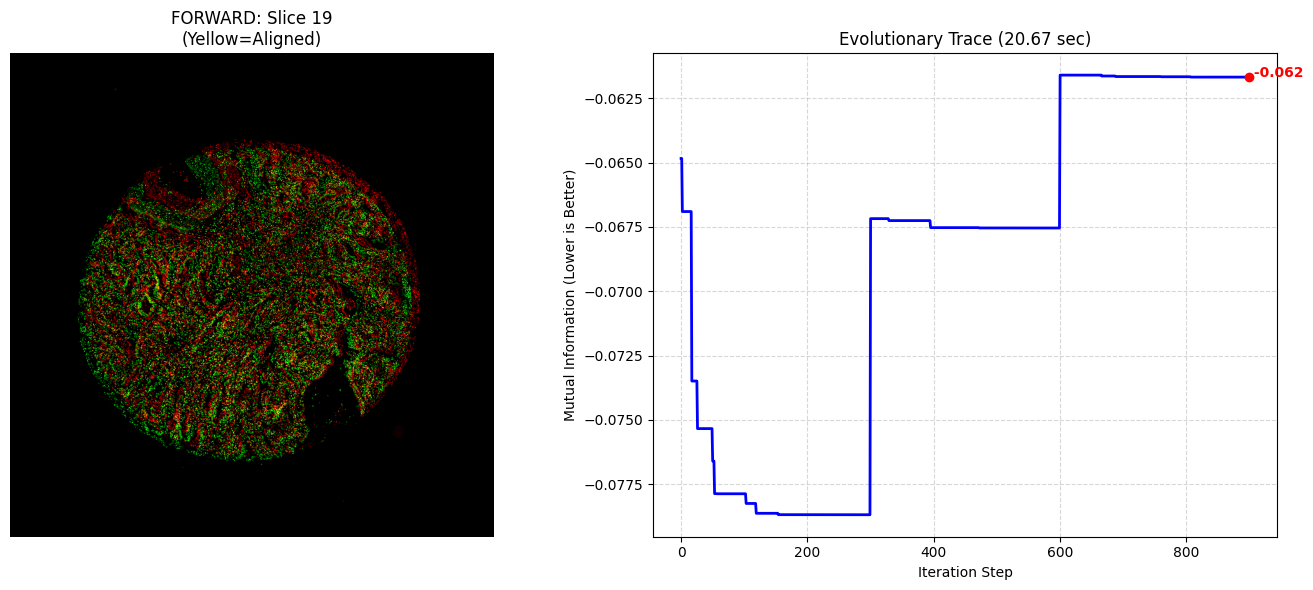

In [6]:

total_slices = len(file_list)
aligned_results = [None] * total_slices
registration_stats = [] 

# Anchor
center_idx = total_slices // 2
center_full = sitk.ReadImage(file_list[center_idx])
aligned_results[center_idx] = center_full
print(f"--- Anchor: Slice {center_idx} ---")

# BACKWARD
print("\n>>> BACKWARD")
current_fixed = center_full
for i in range(center_idx - 1, -1, -1):
    moving = sitk.ReadImage(file_list[i])
    
    # Get Time here
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Backward",
        "Moving_Slice": i,
        "Fixed_Ref": i + 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2)
    })
    
    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "BACKWARD", runtime)
    
    current_fixed = aligned

# FORWARD
print("\n>>> FORWARD")
current_fixed = center_full
for i in range(center_idx + 1, total_slices):
    moving = sitk.ReadImage(file_list[i])
    
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Forward",
        "Moving_Slice": i,
        "Fixed_Ref": i - 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2) 
    })

    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "FORWARD", runtime)
    
    current_fixed = aligned

# Evaluate

In [7]:
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
# Create DataFrame
df = pd.DataFrame(registration_stats)

# Reorder columns
df = df[["Direction", "Moving_Slice", "Fixed_Ref", "Final_Metric", "Iterations", "Runtime(s)"]]

# Sort by Slice Number
df = df.sort_values(by="Moving_Slice")

print("--- REGISTRATION QUALITY & PERFORMANCE REPORT ---")
try:
    display(df) 
except:
    print(df.to_string(index=False))


--- REGISTRATION QUALITY & PERFORMANCE REPORT ---


Direction  Moving_Slice  Fixed_Ref  Final_Metric  Iterations  Runtime(s)
9   Backward             0          1     -0.051780         900       21.03
8   Backward             1          2     -0.109841         900       20.82
7   Backward             2          3     -0.058140         900       21.08
6   Backward             3          4     -0.083108         900       21.26
5   Backward             4          5     -0.064346         900       21.28
4   Backward             5          6     -0.066642         900       21.44
3   Backward             6          7     -0.076916         900       21.72
2   Backward             7          8     -0.052307         900       21.54
1   Backward             8          9     -0.052619         900       21.03
0   Backward             9         10     -0.055382         900       21.39
10   Forward            11         10     -0.085000         900       21.64
11   Forward            12         11     -0.055783         900       21.76
12   Forward            13         12     -0.052712         900       21.31
13   Forward            14         13     -0.053683         900       21.07
14   Forward            15         14     -0.047319         900       21.97
15   Forward            16         15     -0.061567         900       21.30
16   Forward            17         16     -0.044102         900       21.64
17   Forward            18         17     -0.057047         900       21.17
18   Forward            19         18     -0.061682         900       20.67

# Save Result

In [8]:
output_path = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned_CK.ome.tif")
print(f"Saving to {output_path}...")

# Filter out any 'None' values just in case
valid_slices = [img for img in aligned_results if img is not None]

# Convert ITK (X,Y,8) -> Numpy (Z, 8, Y, X)
# GetArrayFromImage returns (8, Y, X). Stacking gives (Z, 8, Y, X).
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"Final Volume Shape: {vol.shape}")

tifffile.imwrite(
    output_path, 
    vol, 
    photometric='minisblack',
    metadata={'axes': 'ZCYX'}
)
print("Done.")

Saving to /data3/junming/3D-TMA-Register/Registered/test/Core_11_CenterOut_Aligned_CK.ome.tif...
Final Volume Shape: (20, 8, 6080, 6080)
Done.


In [9]:
import tifffile
import os
import numpy as np


print("SAVING REGISTERED VOLUME FOR FIJI")

# Define output path
output_tiff = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned_CK.ome.tif")

print(f"\n Output file: {output_tiff}")

# Convert aligned results to volume
valid_slices = [img for img in aligned_results if img is not None]
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"\n Volume Dimensions:")
print(f"   Shape: {vol.shape}")
print(f"   Z-slices: {vol.shape[0]}")
print(f"   Channels: {vol.shape[1]}")
print(f"   Height: {vol.shape[2]} pixels")
print(f"   Width: {vol.shape[3]} pixels")
print(f"   Total size: {vol.nbytes / 1e9:.2f} GB in memory")

# Channel metadata for FIJI
channel_names = ['DAPI', 'CD31', 'GAP43', 'NFP', 'CD3', 'CD163', 'CK', 'AF']

# Save as OME-TIFF with proper metadata for FIJI
print(f"\n Saving OME-TIFF...")

tifffile.imwrite(
    output_tiff, 
    vol,
    photometric='minisblack',
    metadata={
        'axes': 'ZCYX',
        'Channel': {'Name': channel_names[:vol.shape[1]]},
    },
    compression='zlib'  # Compress to reduce file size
)

file_size_mb = os.path.getsize(output_tiff) / 1e6

print(f" SAVED SUCCESSFULLY!")
print(f"   File: {os.path.basename(output_tiff)}")
print(f"   Size: {file_size_mb:.1f} MB")


SAVING REGISTERED VOLUME FOR FIJI

 Output file: /data3/junming/3D-TMA-Register/Registered/test/Core_11_CenterOut_Aligned_CK.ome.tif

 Volume Dimensions:
   Shape: (20, 8, 6080, 6080)
   Z-slices: 20
   Channels: 8
   Height: 6080 pixels
   Width: 6080 pixels
   Total size: 11.83 GB in memory

 Saving OME-TIFF...
 SAVED SUCCESSFULLY!
   File: Core_11_CenterOut_Aligned_CK.ome.tif
   Size: 1638.6 MB


# Quality Check Previews

CHECKING ALL CONSECUTIVE Z-SLICE PAIRS

Using CK channel for quality check
Total Z-slices: 20
Number of consecutive pairs to check: 19

Will check 19 consecutive pairs:
  [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19)]

Displaying all pairs inline...



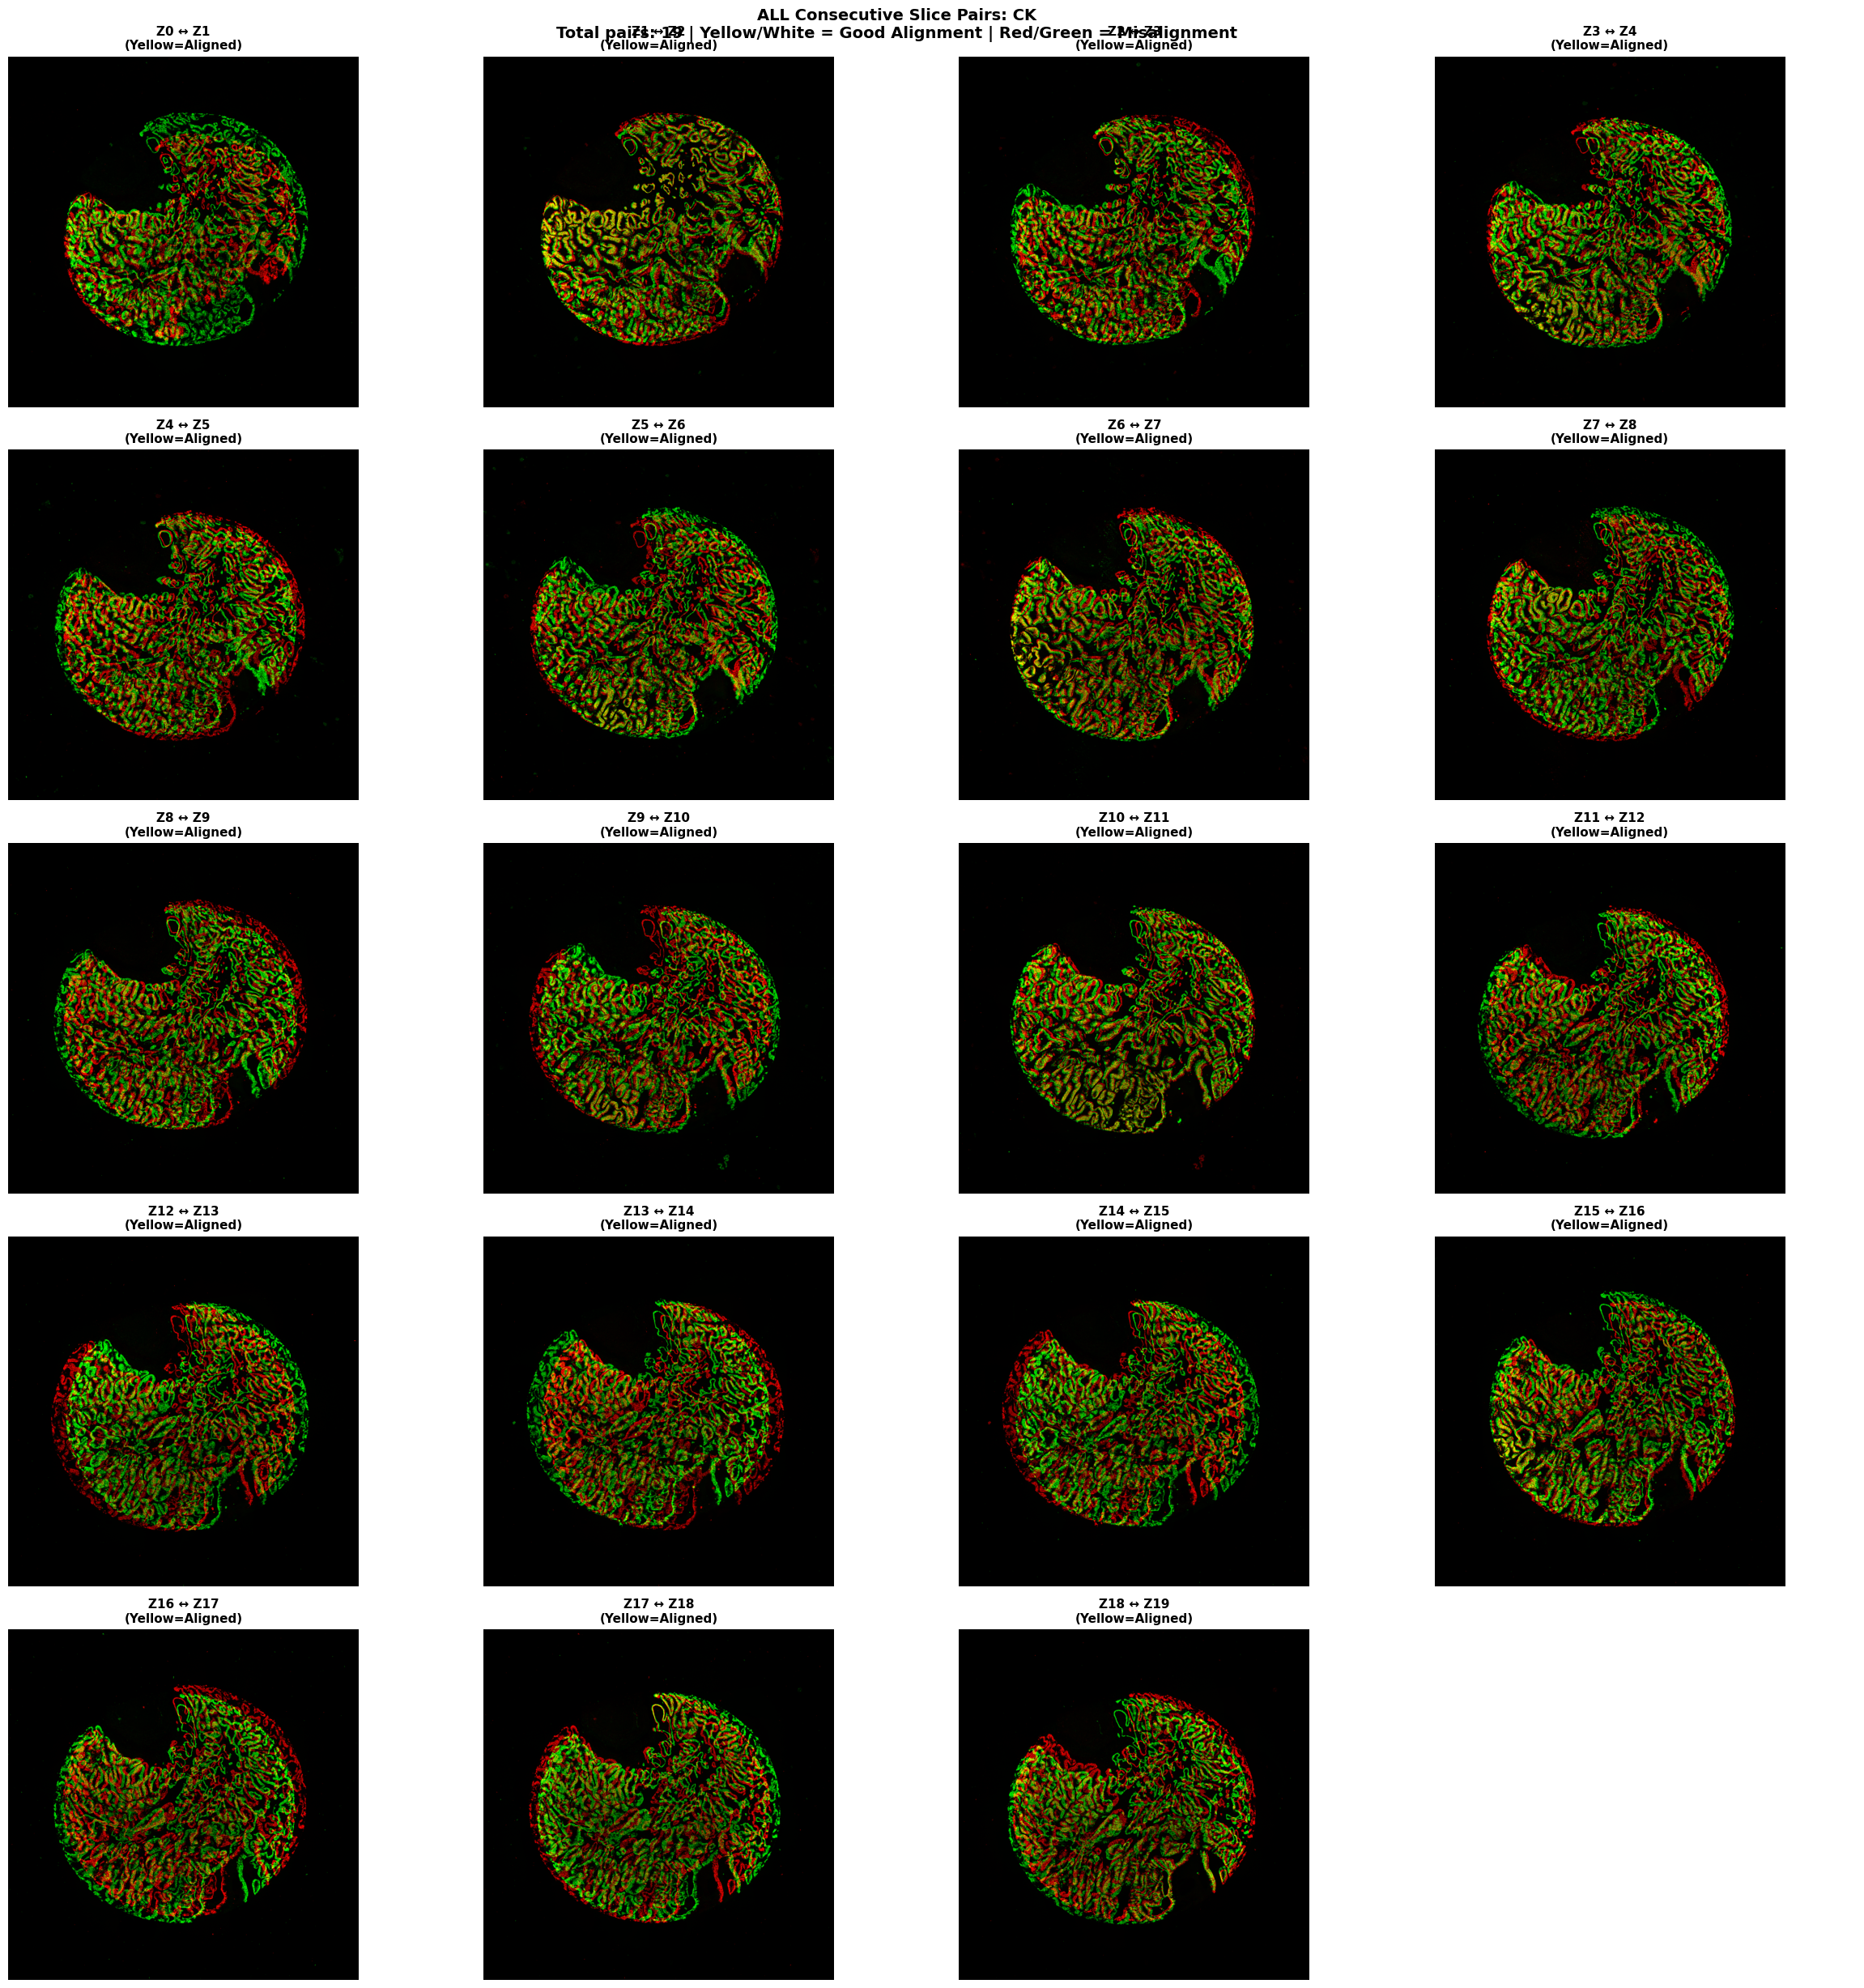

All pairs displayed above


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os

print("CHECKING ALL CONSECUTIVE Z-SLICE PAIRS")


# Correct channel names
channel_names = ['DAPI', 'CD31', 'GAP43', 'NFP', 'CD3', 'CD163', 'CK', 'AF']

# Which channel to check 
check_channel = 6

print(f"\nUsing {channel_names[check_channel]} channel for quality check")
print(f"Total Z-slices: {vol.shape[0]}")
print(f"Number of consecutive pairs to check: {vol.shape[0] - 1}\n")

# Create all consecutive pairs
n_slices = vol.shape[0]
all_pairs = [(i, i+1) for i in range(n_slices - 1)]

print(f"Will check {len(all_pairs)} consecutive pairs:")
print(f"  {all_pairs}\n")


print("Displaying all pairs inline...\n")

# Calculate grid layout
n_pairs = len(all_pairs)
n_cols = min(4, n_pairs)  # Max 4 columns
n_rows = (n_pairs + n_cols - 1) // n_cols

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

# Make sure axes is always 2D array
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes_flat = axes.flatten()

for idx, (z1, z2) in enumerate(all_pairs):
    # Get slices
    slice1 = vol[z1, check_channel, :, :]
    slice2 = vol[z2, check_channel, :, :]
    
    # Normalize robustly
    def norm(x):
        p99 = np.percentile(x, 99.5)
        return np.clip(x / (p99 if p99 > 0 else 1), 0, 1)
    
    s1_norm = norm(slice1)
    s2_norm = norm(slice2)
    
    # Create overlay: RED=slice1, GREEN=slice2
    # YELLOW/WHITE = good overlap
    overlay = np.dstack((s1_norm, s2_norm, np.zeros_like(s1_norm)))
    
    # Display
    axes_flat[idx].imshow(overlay)
    axes_flat[idx].set_title(f'Z{z1} ↔ Z{z2}\n(Yellow=Aligned)', 
                            fontsize=11, fontweight='bold')
    axes_flat[idx].axis('off')

# Hide unused subplots
for idx in range(len(all_pairs), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.suptitle(f'ALL Consecutive Slice Pairs: {channel_names[check_channel]}\n' +
                f'Total pairs: {len(all_pairs)} | Yellow/White = Good Alignment | Red/Green = Misalignment',
                fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("All pairs displayed above")



Creating compact montage of ALL pairs...
Saved compact montage: all_pairs_montage_DAPI.png


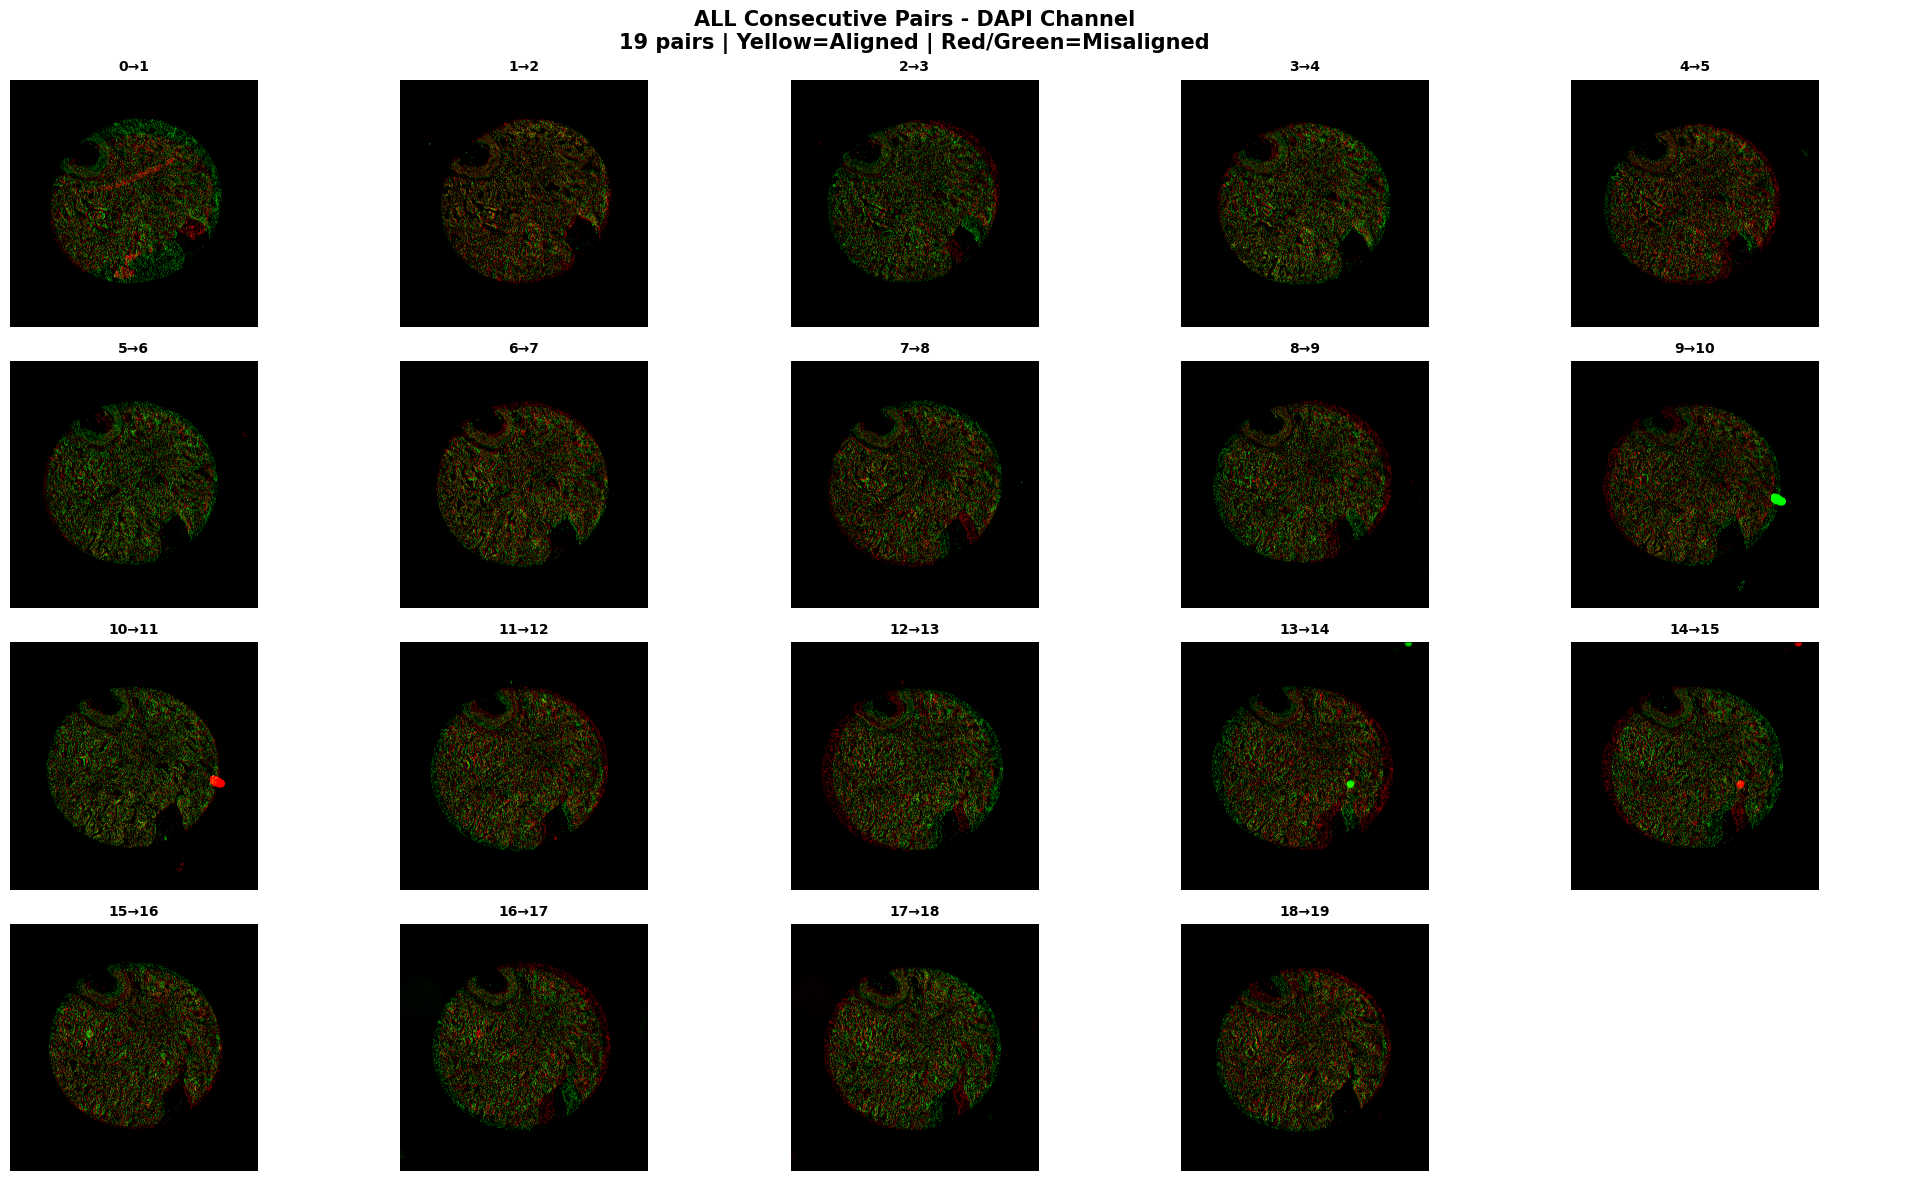

In [11]:

print("Creating compact montage of ALL pairs...")


# Calculate grid for compact view
n_pairs = len(all_pairs)
n_cols = 5  # 5 pairs per row
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

# Handle different axis configurations
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes_flat = axes.flatten()

for idx, (z1, z2) in enumerate(all_pairs):
    # Get slices
    slice1 = vol[z1, check_channel, :, :]
    slice2 = vol[z2, check_channel, :, :]
    
    # Normalize
    def norm(x):
        p99 = np.percentile(x, 99.5)
        return np.clip(x / (p99 if p99 > 0 else 1), 0, 1)
    
    s1_norm = norm(slice1)
    s2_norm = norm(slice2)
    
    # Overlay
    overlay = np.dstack((s1_norm, s2_norm, np.zeros_like(s1_norm)))
    
    axes_flat[idx].imshow(overlay)
    axes_flat[idx].set_title(f'{z1}→{z2}', fontsize=10, fontweight='bold')
    axes_flat[idx].axis('off')

# Hide unused subplots
for idx in range(len(all_pairs), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.suptitle(f'ALL Consecutive Pairs - {channel_names[check_channel]} Channel\n' +
             f'{n_pairs} pairs | Yellow=Aligned | Red/Green=Misaligned',
             fontsize=15, fontweight='bold')
plt.tight_layout()

# Save the montage
montage_path = os.path.join(OUTPUT_FOLDER, f"all_pairs_montage_{channel_names[check_channel]}.png")
plt.savefig(montage_path, dpi=200, bbox_inches='tight')
print(f"Saved compact montage: {os.path.basename(montage_path)}")

plt.show()


CHECK Correlation scores between consecutive slices
   Higher score = better alignment



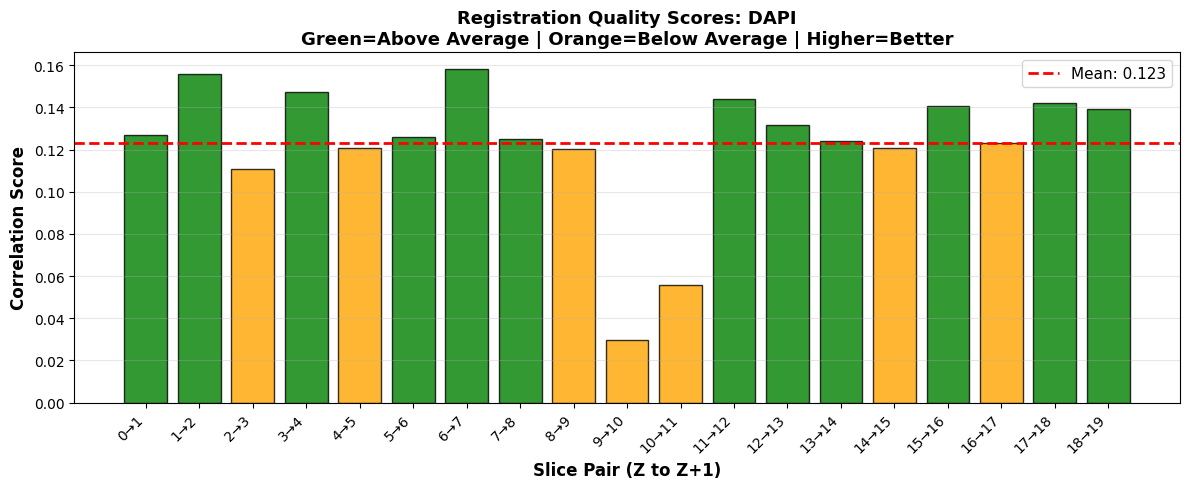

REGISTRATION QUALITY STATISTICS
Channel:          DAPI
Total slices:     20
Mean correlation: 0.1233
Std deviation:    0.0306
Min correlation:  0.0297 (slices 9→10)
Max correlation:  0.1583 (slices 6→7)

INTERPRETATION:
   POOR. Mean score 0.123 < 0.4
     Check registration parameters or problematic slices

 Slices with below-average alignment:
     Slices 9→10: score=0.030
     Slices 10→11: score=0.056

   You may want to visually inspect these specific pairs

 Quality check complete!


In [12]:
print("\nCHECK Correlation scores between consecutive slices")
print("   Higher score = better alignment\n")

from scipy.signal import correlate2d

scores = []

for z in range(n_slices - 1):
    slice1 = vol[z, check_channel, :, :]
    slice2 = vol[z + 1, check_channel, :, :]
    
    # Normalize
    s1 = (slice1 - slice1.mean()) / (slice1.std() + 1e-10)
    s2 = (slice2 - slice2.mean()) / (slice2.std() + 1e-10)
    
    # Cross-correlation at zero lag
    corr = np.sum(s1 * s2) / s1.size
    scores.append(corr)

# Plot scores
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

colors = ['green' if s > np.mean(scores) else 'orange' for s in scores]
bars = ax.bar(range(len(scores)), scores, color=colors, alpha=0.8, edgecolor='black')

# Add mean line
ax.axhline(y=np.mean(scores), color='red', linestyle='--', linewidth=2, 
          label=f'Mean: {np.mean(scores):.3f}')

# Labels
ax.set_xlabel('Slice Pair (Z to Z+1)', fontsize=12, fontweight='bold')
ax.set_ylabel('Correlation Score', fontsize=12, fontweight='bold')
ax.set_title(f'Registration Quality Scores: {channel_names[check_channel]}\n' +
             'Green=Above Average | Orange=Below Average | Higher=Better',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11)

# Add slice pair labels
ax.set_xticks(range(len(scores)))
ax.set_xticklabels([f'{i}→{i+1}' for i in range(len(scores))], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print statistics

print("REGISTRATION QUALITY STATISTICS")

print(f"Channel:          {channel_names[check_channel]}")
print(f"Total slices:     {n_slices}")
print(f"Mean correlation: {np.mean(scores):.4f}")
print(f"Std deviation:    {np.std(scores):.4f}")
print(f"Min correlation:  {np.min(scores):.4f} (slices {np.argmin(scores)}→{np.argmin(scores)+1})")
print(f"Max correlation:  {np.max(scores):.4f} (slices {np.argmax(scores)}→{np.argmax(scores)+1})")

print(f"\nINTERPRETATION:")
mean_score = np.mean(scores)
if mean_score > 0.8:
    print(f"   EXCELLENT! Mean score {mean_score:.3f} > 0.8")
    print(f"     Registration worked very well!")
elif mean_score > 0.6:
    print(f"   GOOD! Mean score {mean_score:.3f} is 0.6-0.8")
    print(f"     Registration is acceptable for visualization")
elif mean_score > 0.4:
    print(f"    FAIR. Mean score {mean_score:.3f} is 0.4-0.6")
    print(f"     Some slices may have alignment issues")
else:
    print(f"   POOR. Mean score {mean_score:.3f} < 0.4")
    print(f"     Check registration parameters or problematic slices")

# Identify problem slices
if scores:
    threshold = np.mean(scores) - np.std(scores)
    problem_slices = [i for i, s in enumerate(scores) if s < threshold]
    
    if problem_slices:
        print(f"\n Slices with below-average alignment:")
        for idx in problem_slices:
            print(f"     Slices {idx}→{idx+1}: score={scores[idx]:.3f}")
        print(f"\n   You may want to visually inspect these specific pairs")

print("="*70)

print("\n Quality check complete!")



# Prepare Download Package

In [13]:
import tifffile
import numpy as np
import os

print("CREATING FIJI-FRIENDLY VERSION (Downsampled)")

# Convert aligned results to volume
valid_slices = [img for img in aligned_results if img is not None]
vol_full = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"\nOriginal volume dimensions:")
print(f"  Shape: {vol_full.shape}")
print(f"  Z-slices: {vol_full.shape[0]}")
print(f"  Channels: {vol_full.shape[1]}")
print(f"  Height × Width: {vol_full.shape[2]} × {vol_full.shape[3]}")
print(f"  Memory size: {vol_full.nbytes / 1e9:.2f} GB")

# Downsample by 2x in XY (keeps all slices and channels)
# This reduces file size by ~75% while keeping quality good
vol_downsampled = vol_full[:, :, ::2, ::2]

print(f"\n Downsampled (2x) dimensions:")
print(f"  Shape: {vol_downsampled.shape}")
print(f"  Memory size: {vol_downsampled.nbytes / 1e9:.2f} GB")
print(f"  Size reduction: {100 * (1 - vol_downsampled.nbytes / vol_full.nbytes):.1f}%")

# Save downsampled version
output_file = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CK_Downsampled2x_FIJI.ome.tif")

print(f"\n Saving file...")
print(f"   Output: {output_file}")

tifffile.imwrite(
    output_file,
    vol_downsampled,
    photometric='minisblack',
    metadata={
        'axes': 'ZCYX',
        'Channel': {
            'Name': ['DAPI', 'CD31', 'GAP43', 'NFP', 'CD3', 'CD163', 'CK', 'AF']
        }
    },
    compression='zlib'
)

file_size_mb = os.path.getsize(output_file) / 1e6

print(f"\n SUCCESS!")
print(f"   File: {os.path.basename(output_file)}")
print(f"   Size: {file_size_mb:.1f} MB")





CREATING FIJI-FRIENDLY VERSION (Downsampled)

Original volume dimensions:
  Shape: (20, 8, 6080, 6080)
  Z-slices: 20
  Channels: 8
  Height × Width: 6080 × 6080
  Memory size: 11.83 GB

 Downsampled (2x) dimensions:
  Shape: (20, 8, 3040, 3040)
  Memory size: 2.96 GB
  Size reduction: 75.0%

 Saving file...
   Output: /data3/junming/3D-TMA-Register/Registered/test/Core_11_CK_Downsampled2x_FIJI.ome.tif

 SUCCESS!
   File: Core_11_CK_Downsampled2x_FIJI.ome.tif
   Size: 433.7 MB
